In [2]:
import torch
from transformers import BertForSequenceClassification, BertTokenizerFast

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import load_dataset

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
import pandas as pd

In [71]:
from datasets import Dataset

In [5]:
# Define checkpoint path
MODEL_PATH = "./checkpoints/model_epoch3"  # 4th epoch was the last one

In [6]:
# Load model and tokenizer from saved folder
model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = BertTokenizerFast.from_pretrained(MODEL_PATH)

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

print(f"Full model loaded from {MODEL_PATH} and moved to {device}")

Full model loaded from ./checkpoints/model_epoch3 and moved to mps


In [8]:
# Load dataset and prepare test dataset
suicide_dataset = load_dataset("vibhorag101/suicide_prediction_dataset_phr")  # Suicide detection dataset

In [103]:
#Out-of-Distribution dataset (messages + labels)
ood_data = [
    {"text": "I feel good today!", "label": 0},  # Non-Suicidal
    {"text": "I feel like dying right now", "label": 1},  # Suicidal
    {"text": "What should I make for dinner?", "label": 0},  # Non-Suicidal
    {"text": "I hate everything about my life, I wish I could disappear", "label": 1},  # Suicidal
    {"text": "What a week! Life is crazy sometimes", "label": 0},  # Non-Suicidal
    {"text": "No one is going to miss if me if I was gone.", "label": 1},  # Suicidal
    {"text": "I'm so stressed with work, I need a break.", "label": 0},  # Non-Suicidal
    {"text": "I really want to hurt myself.", "label": 1},  # Suicidal
    {"text": "I wish I could fly!", "label": 0},  # Non-Suicidal
    {"text": "I want to jump off a cliff.", "label": 1},  # Suicidal
    {"text": "Sometimes I feel so happy, then I feel sad all of a sudden! I don't know why it happens!", "label": 0},  # Non-Suicidal
    {"text": "What if I kill myself?", "label": 1},  # Suicidal
    {"text": "I'm excited right now! I'm going to go kayaking soon.", "label": 0},  # Non-Suicidal
    {"text": "I feel really depressed. I think I should end it", "label": 1},  # Suicidal
    {"text": "I feel really depressed. Im working through it", "label": 0},  # Non-Suicidal
    {"text": "I wish I wasn't here.", "label": 1},  # Suicidal
    {"text": "So nervous! Everything feels like too much", "label": 0},  # Non-Suicidal
    {"text": "This is the end for me. I want to stop everything.", "label": 1},  # Suicidal
    {"text": "Whales are so cool right?", "label": 0},  # Non-Suicidal
    {"text": "My life is over.", "label": 1},  # Suicidal
    {"text": "Things are good!", "label": 0},  # Non-Suicidal
    {"text": "I don't want to be alive.", "label": 1},  # Suicidal
    {"text": "hello!", "label": 0},  # Non-Suicidal
    {"text": "life is over for me. like things feel so empty and I feel unsure about the future", "label": 1},  # Suicidal
    {"text": "I go hiking often. It's a fun activity", "label": 0},  # Non-Suicidal

    
]

In [9]:
def map_labels(example):
    example["label"] = 1 if example["label"] == "suicide" else 0
    return example

suicide_dataset = suicide_dataset.map(map_labels)

In [11]:
def tokenize_function(batch):
    tokenized = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = batch["label"]  # Keep labels
    return tokenized

# Apply tokenization
suicide_dataset = suicide_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/185574 [00:00<?, ? examples/s]

Map:   0%|          | 0/46394 [00:00<?, ? examples/s]

In [104]:
def tokenize_function_ood(batch):
    """Tokenizes text and ensures labels are correctly formatted"""
    tokenized = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = [label for label in batch["label"]]  # Ensure labels are lists
    return tokenized

# Convert OOD data into Hugging Face Dataset format
ood_dataset = Dataset.from_list(ood_data)

# Apply tokenization
ood_dataset = ood_dataset.map(tokenize_function_ood, batched=True)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [12]:
class SuicideDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(item["labels"], dtype=torch.long)
        }

# test sets
# Convert to PyTorch dataset
test_suicide_dataset = SuicideDataset(suicide_dataset["test"])

# Create DataLoader
test_suicide_loader = DataLoader(test_suicide_dataset, batch_size=8, shuffle=False)


In [105]:
# Convert tokenized OOD dataset into a PyTorch dataset
test_ood_dataset = SuicideDataset(ood_dataset)

In [106]:
# Convert to Dataloader
test_ood_loader = DataLoader(test_ood_dataset, batch_size=4, shuffle=False)

In [24]:
import time
from sklearn.metrics import accuracy_score, classification_report

# Start timing
start_time = time.time()

# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []

# Total number of batches in test dataset
num_batches = len(test_suicide_loader)

print(f"Evaluating on {num_batches} batches...\n")

with torch.no_grad():
    for batch_idx, batch in enumerate(test_suicide_loader):
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        # Get predicted class (0 = Non-Suicidal, 1 = Suicidal)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == num_batches:
            print(f"Processed {batch_idx + 1}/{num_batches} batches...")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
end_time = time.time()

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Total Time for Testing: {end_time - start_time:.2f} seconds")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Non-Suicidal", "Suicidal"]))


Evaluating on 5800 batches...

Processed 100/5800 batches...
Processed 200/5800 batches...
Processed 300/5800 batches...
Processed 400/5800 batches...
Processed 500/5800 batches...
Processed 600/5800 batches...
Processed 700/5800 batches...
Processed 800/5800 batches...
Processed 900/5800 batches...
Processed 1000/5800 batches...
Processed 1100/5800 batches...
Processed 1200/5800 batches...
Processed 1300/5800 batches...
Processed 1400/5800 batches...
Processed 1500/5800 batches...
Processed 1600/5800 batches...
Processed 1700/5800 batches...
Processed 1800/5800 batches...
Processed 1900/5800 batches...
Processed 2000/5800 batches...
Processed 2100/5800 batches...
Processed 2200/5800 batches...
Processed 2300/5800 batches...
Processed 2400/5800 batches...
Processed 2500/5800 batches...
Processed 2600/5800 batches...
Processed 2700/5800 batches...
Processed 2800/5800 batches...
Processed 2900/5800 batches...
Processed 3000/5800 batches...
Processed 3100/5800 batches...
Processed 3200/58

In [13]:
# test on new user data
def predict_suicide_risk(text):
    model.eval()  # Set to evaluation mode

    # Tokenize input text
    inputs = tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get prediction label
    predicted_label = torch.argmax(probs, dim=-1).item()
    
    # Map label to class
    label_map = {0: "Non-Suicidal", 1: "Suicidal"}
    return label_map[predicted_label], probs.cpu().numpy()

# User Test
test_message = "I feel hopeless and don't want to live."
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")



Prediction: Suicidal
Confidence Scores: [[0.11786237 0.8821376 ]]


In [14]:
# User Test
test_message = "I hate myself, I want to die."
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.27014002 0.72986   ]]


In [27]:
# User Test
test_message = "I feel sad. But it's ok!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.6972591  0.30274087]]


In [28]:
# User Test
test_message = "I want to die"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.27967495 0.72032505]]


In [29]:
# User Test
test_message = "I'm totally fine!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.83433646 0.16566359]]


In [15]:
# User Test
test_message = "I'm doing ok!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.48050952 0.5194904 ]]


In [31]:
# User Test
test_message = "thank you for your help!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.04278308 0.9572169 ]]


In [32]:
# User Test
test_message = "I'm good!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.5359361  0.46406385]]


In [33]:
# User Test
test_message = "I want to die"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.27967495 0.72032505]]


In [34]:
# User Test
test_message = "I really want to die right now. I don't feel well and I'm feeling bad"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.48259586 0.51740414]]


In [50]:
# User Test
test_message = "I'm doing well"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.8139377  0.18606228]]


In [16]:
# User Test
test_message = "I feel like dying"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.48150542 0.51849455]]


In [102]:
# User Test
test_message = "I go hiking often. It's a fun activity"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.9820754  0.01792459]]


In [97]:
# User Test
test_message = "hello!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.23789354 0.7621065 ]]


In [19]:
# User Test
test_message = "I want to hurt myself"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.43719575 0.5628042 ]]


In [20]:
# User Test
test_message = "Im fine!"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.06701793 0.9329821 ]]


In [21]:
# User Test
test_message = "I feel like dying right now. I hate everything"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Non-Suicidal
Confidence Scores: [[0.53950316 0.4604969 ]]


In [22]:
# User Test
test_message = "what are you up to?"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.09449948 0.9055005 ]]


In [96]:
# User Test
test_message = "I dont want to be alive"
prediction, confidence = predict_suicide_risk(test_message)

print(f"\nPrediction: {prediction}")
print(f"Confidence Scores: {confidence}")


Prediction: Suicidal
Confidence Scores: [[0.21297151 0.7870285 ]]


In [114]:
import time
# Compute ROC-AUC score to determine generalizability
from sklearn.metrics import roc_auc_score

# Start timing
start_time = time.time()

# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []
probabilities = []

# Total number of batches in test dataset
num_batches = len(test_suicide_loader)

print(f"Evaluating on {num_batches} batches...\n")

with torch.no_grad():
    for batch_idx, batch in enumerate(test_suicide_loader):
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        # Get predicted class (0 = Non-Suicidal, 1 = Suicidal)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        probs = torch.nn.functional.softmax(logits, dim=-1)[:, 1].cpu().numpy()  # Probability of class 1 (Suicidal)
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        probabilities.extend(probs)
        true_labels.extend(labels)

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == num_batches:
            print(f"Processed {batch_idx + 1}/{num_batches} batches...")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
end_time = time.time()

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Total Time for Testing: {end_time - start_time:.2f} seconds")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Non-Suicidal", "Suicidal"]))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(true_labels, probabilities)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Evaluating on 5800 batches...

Processed 100/5800 batches...
Processed 200/5800 batches...
Processed 300/5800 batches...
Processed 400/5800 batches...
Processed 500/5800 batches...
Processed 600/5800 batches...
Processed 700/5800 batches...
Processed 800/5800 batches...
Processed 900/5800 batches...
Processed 1000/5800 batches...
Processed 1100/5800 batches...
Processed 1200/5800 batches...
Processed 1300/5800 batches...
Processed 1400/5800 batches...
Processed 1500/5800 batches...
Processed 1600/5800 batches...
Processed 1700/5800 batches...
Processed 1800/5800 batches...
Processed 1900/5800 batches...
Processed 2000/5800 batches...
Processed 2100/5800 batches...
Processed 2200/5800 batches...
Processed 2300/5800 batches...
Processed 2400/5800 batches...
Processed 2500/5800 batches...
Processed 2600/5800 batches...
Processed 2700/5800 batches...
Processed 2800/5800 batches...
Processed 2900/5800 batches...
Processed 3000/5800 batches...
Processed 3100/5800 batches...
Processed 3200/58

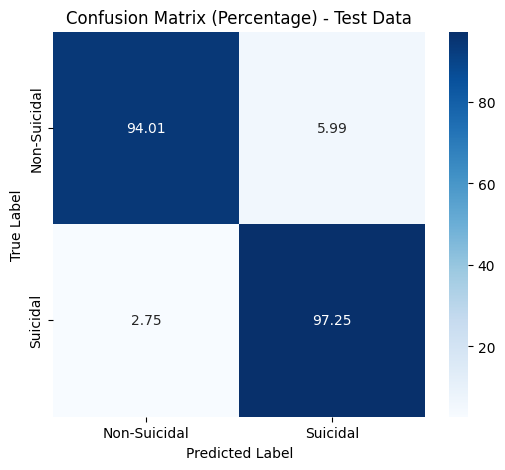

In [115]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Convert Confusion Matrix to Percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix with Percentages
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Non-Suicidal", "Suicidal"], yticklabels=["Non-Suicidal", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage) - Test Data")
plt.show()

In [107]:
# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []

# Evaluate on OOD dataset
with torch.no_grad():
    for batch_idx, batch in enumerate(test_ood_loader):
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

        print(f"Processed {batch_idx + 1}/{num_batches} batches...")

# Compute OOD Accuracy
ood_accuracy = accuracy_score(true_labels, predictions)
print(f"\nOOD Accuracy: {ood_accuracy:.4f}")


Processed 1/5800 batches...
Processed 2/5800 batches...
Processed 3/5800 batches...
Processed 4/5800 batches...
Processed 5/5800 batches...
Processed 6/5800 batches...
Processed 7/5800 batches...

OOD Accuracy: 0.6400


In [108]:
# Compute generalizability score
generalizability_score = ood_accuracy / accuracy

print(f"\n Generalizability Score: {generalizability_score:.4f}")



 Generalizability Score: 0.6693



✅ OOD Accuracy: 0.6400

Classification Report:
              precision    recall  f1-score   support

Non-Suicidal       0.70      0.54      0.61        13
    Suicidal       0.60      0.75      0.67        12

    accuracy                           0.64        25
   macro avg       0.65      0.64      0.64        25
weighted avg       0.65      0.64      0.64        25



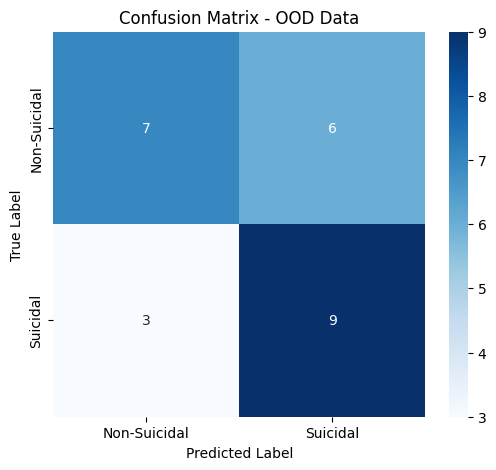

In [110]:
# Set model to evaluation mode
model.eval()

true_labels = []
predictions = []

# Evaluate on OOD dataset
with torch.no_grad():
    for batch in test_ood_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Compute OOD Accuracy
ood_accuracy = accuracy_score(true_labels, predictions)
print(f"\nOOD Accuracy: {ood_accuracy:.4f}")

# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Non-Suicidal", "Suicidal"]))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Suicidal", "Suicidal"], yticklabels=["Non-Suicidal", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - OOD Data")
plt.show()

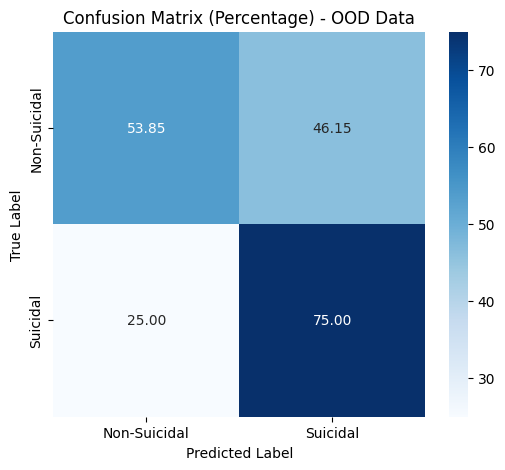

In [111]:
# Convert Confusion Matrix to Percentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix with Percentages
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Non-Suicidal", "Suicidal"], yticklabels=["Non-Suicidal", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage) - OOD Data")
plt.show()

In [116]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-1